In [1]:
! mkdir MAgent && cd MAgent && mkdir build && cd build && mkdir render && cd render && cd ../../..

In [2]:
! pip install pettingzoo[magent]

     |████████████████████████████████| 756 kB 9.2 MB/s 
     |████████████████████████████████| 1.5 MB 48.9 MB/s 
     |████████████████████████████████| 1.7 MB 43.9 MB/s 
     |████████████████████████████████| 21.8 MB 1.4 MB/s 
  Created wheel for pettingzoo: filename=PettingZoo-1.14.0-py3-none-any.whl size=874226 sha256=edd884290f011853be3cddc38a47e7f8f10b77b1080b10e10082cdfbf681e11c
  Stored in directory: /root/.cache/pip/wheels/9e/a7/ad/c4d2a42ddfb4b6ceb16a0ca730ae46d8621233408522053338
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616820 sha256=20ce471e5f766e62d3b91f2d0cf74575602fd474257a41b1ef44e23474e32449
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
Successfully built pettingzoo gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [3]:
import torch
from collections import deque
from random import shuffle

def gen_params(N,size):
  ret = []
  for i in range(N):
    vec = torch.randn(size) / 10.
    vec.requires_grad = True
    ret.append(vec)
  return ret

def softmax_policy(qvals,temp=0.9):
    soft = torch.exp(qvals/temp) / torch.sum(torch.exp(qvals/temp))
    action = torch.multinomial(soft,1)
    return action

In [4]:
import magent
import numpy as np
import math
from scipy.spatial.distance import cityblock

map_size = 30
env = magent.GridWorld("battle", map_size=map_size)
env.set_render_dir("MAgent/build/render")
team1, team2 = env.get_handles()

In [5]:
hid_layer = 25
in_state = 338
in_mean = 21
act_space = 21
layers = [(in_state, 160), (in_mean, 10), (170, hid_layer), (hid_layer, act_space)]
params = gen_params(2, in_state * 160 + in_mean * 10 +  170 * hid_layer + hid_layer * act_space)
map_size = 30
width = height = map_size
n1 = n2 = 16
gap = 1
epochs = 100
replay_size = 70
batch_size = 25

side1 = int(math.sqrt(n1)) * 2
pos1 = []
for x in range(width//2 - gap - side1, width//2 - gap, 2):
  for y in range((height - side1)//2, (height - side1)//2 + side1, 2):
    pos1.append([x, y, 0])

side2 = int(math.sqrt(n1)) * 2
pos2 = []
for x in range(width//2 + gap, width//2 + gap + side2, 2):
  for y in range((height - side2)//2, (height - side2)//2 + side2, 2):
    pos2.append([x, y, 0])

env.reset()
env.add_agents(team1, method="custom", pos=pos1)
env.add_agents(team2, method="custom", pos=pos2)

In [31]:
def qfunc(s,theta,layers=[(4,20),(20,2)],afn=torch.tanh):
    state = s[:in_state]
    mean = s[in_state:]
    l1n = layers[0] 
    l1s = np.prod(l1n)
    theta_1 = theta[0:l1s].reshape(l1n)

    l2n = layers[1]
    l2s = np.prod(l2n)
    theta_2 = theta[l1s:l2s+l1s].reshape(l2n)

    l3n = layers[2]
    l3s = np.prod(l3n)
    theta_3 = theta[l2s+l1s:l3s+l2s+l1s].reshape(l3n)

    l4n = layers[3]
    l4s = np.prod(l4n)
    theta_4 = theta[l3s+l2s+l1s:l4s+l3s+l2s+l1s].reshape(l4n)

    bias1 = torch.ones((1,theta_1.shape[1]))
    bias2 = torch.ones((1,theta_2.shape[1]))
    bias3 = torch.ones((1,theta_3.shape[1]))

    l1 = state @ theta_1 + bias1
    l1 = torch.nn.functional.elu(l1)
    l2 = mean @ theta_2 + bias2
    l2 = torch.nn.functional.elu(l2)

    l3 = torch.cat((l1, l2), 1)
    l3 = l3 @ theta_3 + bias3

    l4 = afn(l3 @ theta_4)

    return l4.flatten()

In [7]:
def get_neighbors(j, pos_list, r=6):
  neighbors = []
  pos_j = pos_list[j]
  for i, pos in enumerate(pos_list):
    if i == j:
      continue
    dist = cityblock(pos, pos_j)
    if dist < r:
      neighbors.append(i)
  return neighbors

In [8]:
def get_onehot(a, l=21):
  x = torch.zeros(l)
  x[a] = 1
  return x

def get_scalar(v):
  return torch.argmax(v)

def get_mean_field(j, pos_list, act_list, r=7, l=21):
  neighbors = get_neighbors(j, pos_list, r=r)
  mean_field = torch.zeros(l)
  for k in neighbors:
    act_ = act_list[k]
    act = get_onehot(act_)
    mean_field += act
  tot = mean_field.sum()
  mean_field = mean_field / tot if tot > 0 else mean_field
  return mean_field

In [9]:
def infer_acts(obs, param, layers, pos_list, acts, act_space=21, num_iter=5, temp=0.5):
  N = acts.shape[0]
  mean_fields = torch.zeros(N, act_space)
  acts_ = acts.clone()
  qvals = torch.zeros(N, act_space)

  for i in range(num_iter):
    for j in range(N):
      mean_fields[j] = get_mean_field(j, pos_list, acts_)

    for j in range(N):
      state = torch.cat((obs[j].flatten(), mean_fields[j]))
      qs = qfunc(state.detach(), param, layers=layers)
      qvals[j, : ] = qs[:]
      acts_[j] = softmax_policy(qs.detach(), temp=temp)
  return acts_, mean_fields, qvals

def init_mean_field(N, act_space=21):
  mean_fields = torch.abs(torch.rand(N, act_space))
  for i in range(mean_fields.shape[0]):
    mean_fields[i] = mean_fields[i] / mean_fields[i].sum()
  return mean_fields

In [24]:
def train(batch_size, replay, param, layers, J=64, gamma=0.5, lr=0.001):
  ids = np.random.randint(low=0, high=len(replay), size=batch_size)
  exps = [replay[idx] for idx in ids]
  losses = []
  jobs = torch.stack([ex[0] for ex in exps]).detach()
  jacts = torch.stack([ex[1] for ex in exps]).detach()
  jrewards = torch.stack([ex[2] for ex in exps]).detach()
  jmeans = torch.stack([ex[3] for ex in exps]).detach()
  vs = torch.stack([ex[4] for ex in exps]).detach()
  qs = []
  for h in range(batch_size):
    state = torch.cat((jobs[h].flatten(), jmeans[h]))
    qs.append(qfunc(state.detach(), param, layers=layers))
  qvals = torch.stack(qs)
  target = qvals.clone().detach()
  target[ : , jacts] = jrewards + gamma * torch.max(vs, dim=1)[0]
  loss = torch.sum(torch.pow(qvals - target.detach(), 2))
  losses.append(loss.detach().item())
  loss.backward()
  with torch.no_grad():
    param = param - lr * param.grad
  param.requires_grad = True
  return np.array(losses).mean()

In [32]:
N1 = env.get_num(team1)
N2 = env.get_num(team2)
acts_1 = torch.randint(low=0, high=act_space, size=(N1,))
acts_2 = torch.randint(low=0, high=act_space, size=(N2,))

replay1 = deque(maxlen=replay_size)
replay2 = deque(maxlen=replay_size)

qnext1 = torch.zeros(N1)
qnext2 = torch.zeros(N2)

act_means1 = init_mean_field(N1, act_space)
act_means2 = init_mean_field(N2, act_space)

losses1 = []
losses2 = []

In [12]:
def team_step(team, param, acts, layers):
  obs = env.get_observation(team)
  ids = env.get_agent_id(team)
  obs_small = torch.from_numpy(obs[0][ :, :, :, [1, 4]])
  agent_pos = env.get_pos(team)
  acts, act_means, qvals = infer_acts(obs_small, param, layers, agent_pos, acts)
  return acts, act_means, qvals, obs_small, ids

def add_to_replay(replay, obs_small, acts, rewards, act_means, qnext):
  for j in range(rewards.shape[0]):
    exp = (obs_small[j], acts[j], rewards[j], act_means[j], qnext[j])
    replay.append(exp)
  return replay

In [ ]:
from tqdm import tqdm

for i in tqdm(range(epochs)):
  done = False
  step_ct = 0
  while not done:
    acts_1, act_means1, qvals1, obs_small_1, ids_1 = team_step(team1, params[0], acts_1, layers)
    env.set_action(team1, acts_1.detach().numpy().astype(np.int32))
    acts_2, act_means2, qvals2, obs_small_2, ids_2 = team_step(team2, params[1], acts_2, layers)
    env.set_action(team2, acts_2.detach().numpy().astype(np.int32))
    done = env.step()
    _, _, qnext1, _, ids_1 = team_step(team1, params[0], acts_1, layers)
    _, _, qnext2, _, ids_2 = team_step(team2, params[1], acts_2, layers)
    env.render()
    rewards1 = torch.from_numpy(env.get_reward(team1)).float()
    rewards2 = torch.from_numpy(env.get_reward(team2)).float()
    replay1 = add_to_replay(replay1, obs_small_1, acts_1, rewards1, act_means1, qnext1)
    replay2 = add_to_replay(replay2, obs_small_2, acts_2, rewards2, act_means2, qnext2)
    shuffle(replay1)
    shuffle(replay2)
    ids_1_ = list(zip(np.arange(ids_1.shape[0]), ids_1))
    ids_2_ = list(zip(np.arange(ids_2.shape[0]), ids_2))
    env.clear_dead()
    ids_1 = env.get_agent_id(team1)
    ids_2 = env.get_agent_id(team2)
    ids_1_ = [i for (i, j) in ids_1_ if j in ids_1]
    ids_2_ = [i for (i, j) in ids_2_ if j in ids_2]
    acts_1 = acts_1[ids_1_]
    acts_2 = acts_2[ids_2_]
    step_ct += 1
    if step_ct > 250:
      break
    if len(replay1) > batch_size and len(replay2) > batch_size:
      loss1 = train(batch_size, replay1, params[0], layers=layers, J=N1)
      loss2 = train(batch_size, replay2, params[1], layers=layers, J=N2)
      losses1.append(loss1)
      losses2.append(loss2)

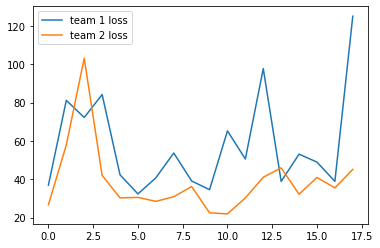

In [37]:
import matplotlib.pyplot as plt

plt.plot(losses1, label = "team 1 loss")
plt.plot(losses2, label = "team 2 loss")
plt.legend()
plt.show()